In [87]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [99]:
df = pd.read_csv("C:\Ciencia de Dados\Projeto_Brasileirao\campeonato-brasileiro-cartoes.csv", sep=",", encoding="iso-8859-1")
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\C'
<>:1: SyntaxWarning: invalid escape sequence '\C'
C:\Users\saulo\AppData\Local\Temp\ipykernel_11392\3186200728.py:1: SyntaxWarning: invalid escape sequence '\C'
  df = pd.read_csv("C:\Ciencia de Dados\Projeto_Brasileirao\campeonato-brasileiro-cartoes.csv", sep=",", encoding="iso-8859-1")


,partida_id,rodata,clube,cartao,atleta,num_camisa,posicao,minuto
0,4607,1,Figueirense,Amarelo,Paulo Roberto da Silva,28.0,NaN,66
1,4607,1,Figueirense,Amarelo,Thiago Heleno,4.0,Zagueiro,44
2,4608,1,Internacional,Amarelo,AndrÃ©s D'Alessandro,10.0,Meio-campo,72
3,4608,1,Vitoria,Amarelo,Marcelo Machado dos Santos,29.0,NaN,86
4,4608,1,Vitoria,Amarelo,Mansur,NaN,Zagueiro,10


In [89]:

# Tratatamento de Dados
df.isnull().sum()

# Preencher valores nulos
df["posicao"] = df["posicao"].fillna("Não Informado")
df.drop(columns=["num_camisa"], inplace=True)

#Corrigir nome da coluna
df.rename(columns={"rodata":"rodada"}, inplace=True)

#Corrigir erros de digitação em posicao
df["posicao"] = df["posicao"].replace({"Zagueira":"Zagueiro"})

# Adicionar coluna 'temporada' baseada em 'rodada' e 'partida_id'
df["rodada"] = pd.to_numeric(df["rodada"], errors="coerce")
df["partida_id"] = pd.to_numeric(df["partida_id"], errors="coerce")

df = df.sort_values(["partida_id"]).reset_index(drop=True)
inicio_bloco_r1 = (df["rodada"].eq(1) & ~df["rodada"].shift().eq(1))
df["temporada_id"] = inicio_bloco_r1.cumsum()
df["temporada"] = df["temporada_id"] + 2013 
df.drop(columns=["temporada_id"], inplace=True)
df.tail(10)

,partida_id,rodada,clube,cartao,atleta,posicao,minuto,temporada
20943,8784,38,Palmeiras,Amarelo,EstÃªvÃ£o,Meio-campo,90+3,2024
20944,8784,38,Fluminense,Amarelo,GermÃ¡n Cano,Atacante,41,2024
20945,8784,38,Fluminense,Amarelo,KauÃ£ Elias,Atacante,90+4,2024
20946,8785,38,Corinthians,Amarelo,Hugo Souza,Goleiro,64,2024
20947,8785,38,Gremio,Amarelo,Miguel Monsalve,Meio-campo,90+2,2024
20948,8785,38,Corinthians,Amarelo,Matheus Bidu,Zagueiro,90+6,2024
20949,8785,38,Corinthians,Amarelo,AndrÃ© Carrillo,Meio-campo,54,2024
20950,8785,38,Corinthians,Vermelho,JosÃ© AndrÃ©s MartÃ­nez,Meio-campo,79,2024
20951,8785,38,Gremio,Amarelo,Reinaldo Manoel da Silva,Zagueiro,25,2024
20952,8785,38,Gremio,Vermelho,Douglas Moreira,Meio-campo,79,2024


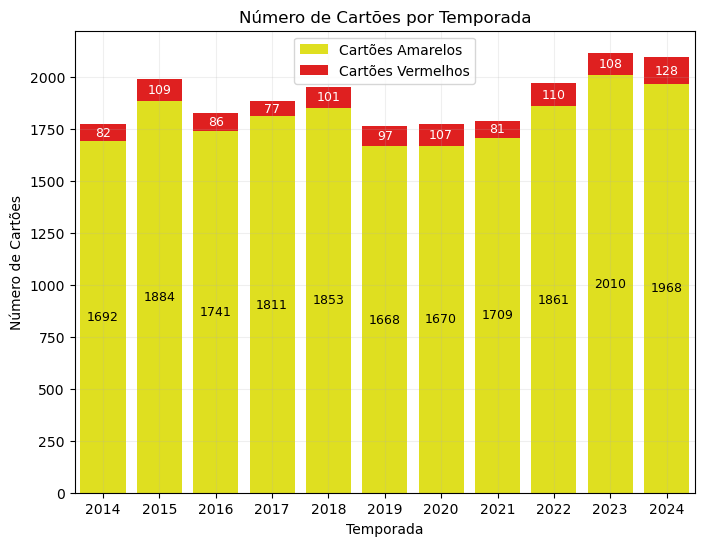

In [90]:
# Plotando número de cartões por temporada
plt.figure(figsize=(8, 6))
cartoes_por_temporada_df = df.groupby("temporada")["cartao"].value_counts().unstack(fill_value=0).reset_index()

sns.barplot(x="temporada", y="Amarelo", data=cartoes_por_temporada_df, color="yellow", label="Cartões Amarelos")
sns.barplot(x="temporada", y="Vermelho", data=cartoes_por_temporada_df, color="red", label="Cartões Vermelhos", bottom=cartoes_por_temporada_df["Amarelo"])

for idx, row in cartoes_por_temporada_df.iterrows():
    plt.text(idx, row["Amarelo"] / 2, str(row["Amarelo"]), ha="center", va="center", color="black", fontsize=9)
    plt.text(idx, row["Amarelo"] + row["Vermelho"] / 2, str(row["Vermelho"]), ha="center", va="center", color="white", fontsize=9)

plt.title("Número de Cartões por Temporada")
plt.xlabel("Temporada")
plt.ylabel("Número de Cartões")
plt.legend()
plt.grid(linestyle="-", alpha=0.2)
plt.show()

C:\Users\saulo\AppData\Local\Temp\ipykernel_11392\1868396065.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cartoes_por_posicao_df = df.groupby("posicao")["cartao"].value_counts().unstack(fill_value=0).reset_index()


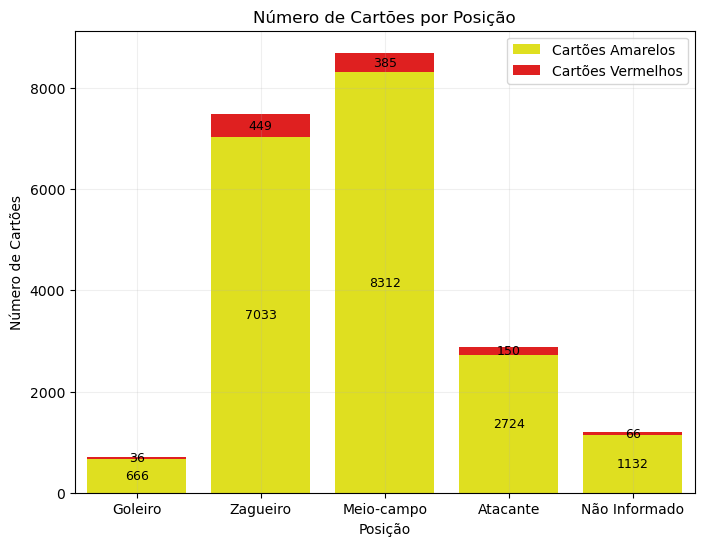

In [91]:
ordem_posicoes = [
    "Goleiro",
    "Zagueiro",
    "Meio-campo",
    "Atacante",
    "Não Informado"
]
df["posicao"] = pd.Categorical(df["posicao"], categories=ordem_posicoes, ordered=True)

# Agrupamento
cartoes_por_posicao_df = df.groupby("posicao")["cartao"].value_counts().unstack(fill_value=0).reset_index()
cartoes_por_posicao_df["Amarelo"] = cartoes_por_posicao_df.get("Amarelo", 0)
cartoes_por_posicao_df["Vermelho"] = cartoes_por_posicao_df.get("Vermelho", 0)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x="posicao",y="Amarelo",data=cartoes_por_posicao_df,color="yellow",label="Cartões Amarelos",order=ordem_posicoes)
sns.barplot(x="posicao",y="Vermelho",data=cartoes_por_posicao_df,color="red",label="Cartões Vermelhos",bottom=cartoes_por_posicao_df["Amarelo"],order=ordem_posicoes)

# Labels no meio das barras
for idx, row in cartoes_por_posicao_df.iterrows():
    if pd.isna(row["posicao"]):  # pular categorias ausentes
        continue
    plt.text(idx, row["Amarelo"] / 2, str(row["Amarelo"]),
             ha="center", va="center", color="black", fontsize=9)
    plt.text(idx, row["Amarelo"] + row["Vermelho"] / 2, str(row["Vermelho"]),
             ha="center", va="center", color="black", fontsize=9)

plt.title("Número de Cartões por Posição")
plt.xlabel("Posição")
plt.ylabel("Número de Cartões")
plt.legend()
plt.grid(linestyle="-", alpha=0.2)
plt.show()


In [92]:
# Rodadas com mais cartões
cartoes_por_rodada_df = df.groupby("rodada")["cartao"].value_counts().unstack(fill_value=0).reset_index()
cartoes_por_rodada_df["Amarelo"] = cartoes_por_rodada_df.get("Amarelo", 0)
cartoes_por_rodada_df["Vermelho"] = cartoes_por_rodada_df.get("Vermelho", 0)
cartoes_por_rodada_df["Total"] = cartoes_por_rodada_df["Amarelo"] + cartoes_por_rodada_df["Vermelho"]
top_10_rodadas = cartoes_por_rodada_df.nlargest(10, "Total")
top_10_rodadas

cartao,rodada,Amarelo,Vermelho,Total
36,37,591,44,635
2,3,561,34,595
13,14,565,29,594
3,4,565,28,593
4,5,567,23,590
17,18,561,29,590
6,7,540,40,580
5,6,545,33,578
12,13,544,32,576
7,8,539,34,573


In [93]:
# Minutos com mais cartões
cartoes_por_minuto_df = df.groupby("minuto")["cartao"].value_counts().unstack(fill_value=0).reset_index()
cartoes_por_minuto_df["Amarelo"] = cartoes_por_minuto_df.get("Amarelo", 0)
cartoes_por_minuto_df["Vermelho"] = cartoes_por_minuto_df.get("Vermelho", 0)
cartoes_por_minuto_df["Total"] = cartoes_por_minuto_df["Amarelo"] + cartoes_por_minuto_df["Vermelho"]

top_10_minutos = cartoes_por_minuto_df.nlargest(10, "Total")
top_10_minutos


cartao,minuto,Amarelo,Vermelho,Total
115,90+3,350,42,392
104,90+1,344,26,370
114,90+2,334,35,369
116,90+4,331,37,368
103,90,333,31,364
101,89,321,22,343
98,86,318,24,342
100,88,321,13,334
97,85,290,25,315
94,82,290,21,311


In [94]:
# Jogadores com mais cartões
cartoes_por_jogador_df = df.groupby("atleta")["cartao"].value_counts().unstack(fill_value=0).reset_index()
cartoes_por_jogador_df["Amarelo"] = cartoes_por_jogador_df.get("Amarelo", 0)
cartoes_por_jogador_df["Vermelho"] = cartoes_por_jogador_df.get("Vermelho", 0)
cartoes_por_jogador_df["Total"] = cartoes_por_jogador_df["Amarelo"] + cartoes_por_jogador_df["Vermelho"]

top_10_jogadores = cartoes_por_jogador_df.nlargest(10, "Total")
top_10_jogadores

cartao,atleta,Amarelo,Vermelho,Total
2042,Thiago Heleno,76,7,83
619,Fagner,69,5,74
1981,Samuel Xavier,69,5,74
1820,Reinaldo Manoel da Silva,68,4,72
2154,Walter Kannemann,67,5,72
219,Bruno Henrique,66,3,69
914,Jadson,63,5,68
1274,Lucas Rafael AraÃºjo Lima,64,3,67
1031,JosÃ© Rafael Vivian,59,6,65
637,Felipe Melo,60,4,64


In [95]:
# Times com mais cartões
cartoes_por_time_df = df.groupby("clube")["cartao"].value_counts().unstack(fill_value=0).reset_index()
cartoes_por_time_df["Amarelo"] = cartoes_por_time_df.get("Amarelo",0)
cartoes_por_time_df["Vermelho"] = cartoes_por_time_df.get("Vermelho",0)
cartoes_por_time_df["Total"] = cartoes_por_time_df["Amarelo"] + cartoes_por_time_df["Vermelho"]

# Adicionando coluna de ranking e usando como index
cartoes_por_time_df["Rank"] = cartoes_por_time_df["Total"].rank(ascending=False, method="min").astype(int)
cartoes_por_time_df.set_index("Rank", inplace=True)
cartoes_por_time_df.reset_index(inplace=True)

top_10_times = cartoes_por_time_df.nlargest(10, "Total")
top_10_times

cartao,Rank,clube,Amarelo,Vermelho,Total
18,1,Fluminense,1011,65,1076
30,2,Sao Paulo,1000,51,1051
22,3,Internacional,982,56,1038
25,4,Palmeiras,982,51,1033
3,5,Atletico-MG,950,44,994
1,6,Athletico-PR,938,39,977
29,7,Santos,898,52,950
17,8,Flamengo,884,49,933
21,8,Gremio,889,44,933
11,10,Corinthians,866,39,905
